In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


## 1. Data Preparation

We download the MNIST dataset and split it into 60% training, 20% validation, and 20% test sets using stratified splitting.


In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

X = dataset.data.numpy() #images
y = dataset.targets.numpy() #labels

train_idx, temp_idx, y_train, y_temp = train_test_split(
    np.arange(len(y)), y, test_size=0.4, stratify=y, random_state=42
)
val_idx, test_idx, y_val, y_test = train_test_split(
    temp_idx, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


## 2. Model Definition: Feedforward Neural Network

We implement a simple feedforward neural network with two hidden layers and ReLU activations.


In [11]:
class SimpleNN(nn.Module):
    def __init__(self, input_size=784, hidden1=128, hidden2=64, output_size=10):
        super(SimpleNN, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, output_size)
        )

    def forward(self, x):
        return self.model(x)


## 3. Training and Evaluation Functions

These functions handle the custom training loop and evaluation using cross entropy loss and SGD optimizer.


In [12]:
def train(model, optimizer, criterion, loader):
    model.train()
    running_loss, correct = 0.0, 0
    for images, labels in loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

    return running_loss / len(loader.dataset), correct / len(loader.dataset)

def evaluate(model, criterion, loader):
    model.eval()
    running_loss, correct = 0.0, 0
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
    return running_loss / len(loader.dataset), correct / len(loader.dataset)


## 4. Train the Model

We use stochastic gradient descent with a learning rate of 0.01 and train for 10 epochs.


In [13]:
model = SimpleNN()
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

epochs = 10
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    train_loss, train_acc = train(model, optimizer, criterion, train_loader)
    val_loss, val_acc = evaluate(model, criterion, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")


Epoch 1 | Train Loss: 2.0799, Accuracy: 0.4893 | Val Loss: 1.5794, Accuracy: 0.6969
Epoch 2 | Train Loss: 0.9849, Accuracy: 0.7779 | Val Loss: 0.6551, Accuracy: 0.8324
Epoch 3 | Train Loss: 0.5357, Accuracy: 0.8562 | Val Loss: 0.4754, Accuracy: 0.8673
Epoch 4 | Train Loss: 0.4209, Accuracy: 0.8838 | Val Loss: 0.4045, Accuracy: 0.8885
Epoch 5 | Train Loss: 0.3709, Accuracy: 0.8956 | Val Loss: 0.3694, Accuracy: 0.8977
Epoch 6 | Train Loss: 0.3423, Accuracy: 0.9028 | Val Loss: 0.3436, Accuracy: 0.9019
Epoch 7 | Train Loss: 0.3220, Accuracy: 0.9066 | Val Loss: 0.3283, Accuracy: 0.9063
Epoch 8 | Train Loss: 0.3065, Accuracy: 0.9113 | Val Loss: 0.3169, Accuracy: 0.9100
Epoch 9 | Train Loss: 0.2929, Accuracy: 0.9148 | Val Loss: 0.3059, Accuracy: 0.9126
Epoch 10 | Train Loss: 0.2807, Accuracy: 0.9186 | Val Loss: 0.2941, Accuracy: 0.9159


## 5. Plot Training and Validation Loss and Accuracy


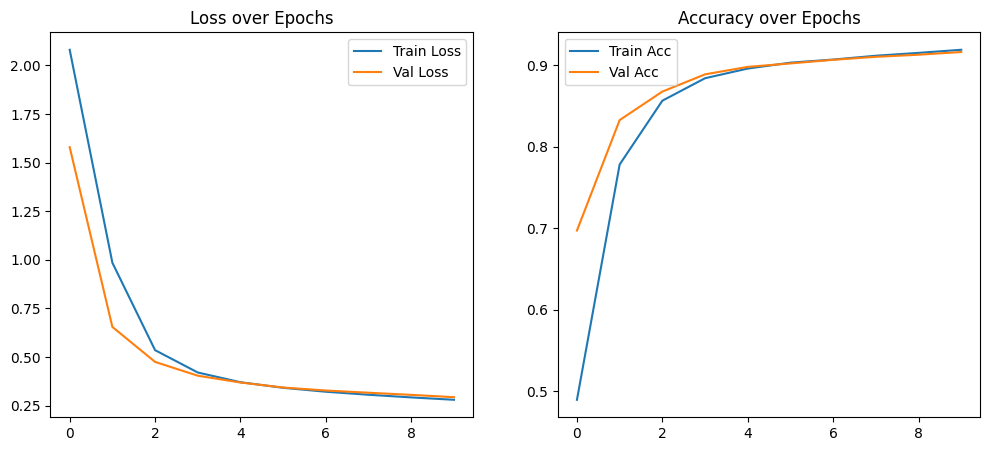

In [14]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss over Epochs")

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend()
plt.title("Accuracy over Epochs")
plt.show()


## 6. Evaluate on Test Set and Show Confusion Matrix


Test Accuracy: 0.9144


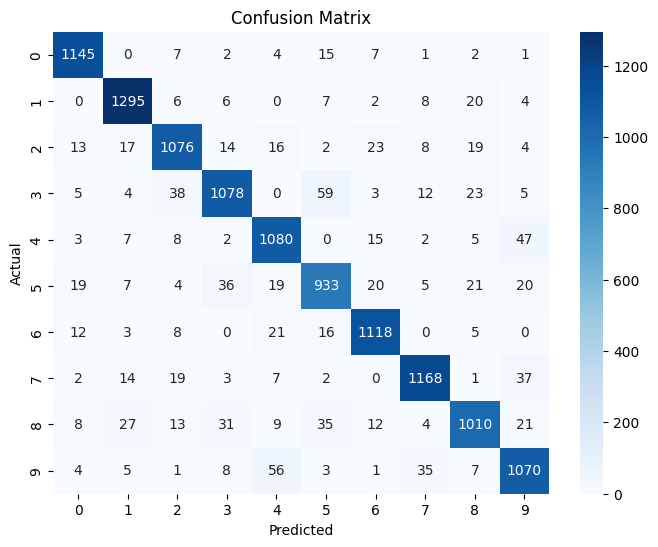

In [15]:
model.eval()
y_preds, y_true = [], []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_preds.extend(preds.numpy())
        y_true.extend(labels.numpy())

test_accuracy = accuracy_score(y_true, y_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")

cm = confusion_matrix(y_true, y_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## 1. Varying Learning Rates


 Testing Learning Rate: 0.1

 Testing Learning Rate: 0.01

 Testing Learning Rate: 0.001

 Testing Learning Rate: 0.0001


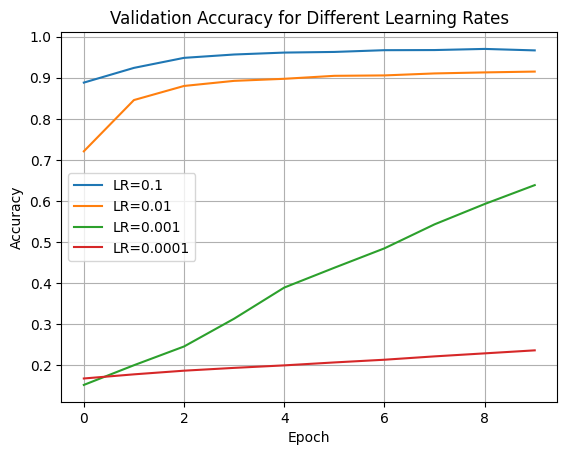

In [16]:
learning_rates = [0.1, 0.01, 0.001, 0.0001]
results_lr = {}

for lr in learning_rates:
    print(f"\n Testing Learning Rate: {lr}")
    
    model = SimpleNN()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(10):
        train_loss, train_acc = train(model, optimizer, criterion, train_loader)
        val_loss, val_acc = evaluate(model, criterion, val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

    results_lr[lr] = (train_losses, val_losses, train_accs, val_accs)

    plt.plot(val_accs, label=f"LR={lr}")

plt.title("Validation Accuracy for Different Learning Rates")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


## 2. Varying Batch Sizes


 Testing Batch Size: 16

 Testing Batch Size: 32

 Testing Batch Size: 64

 Testing Batch Size: 128


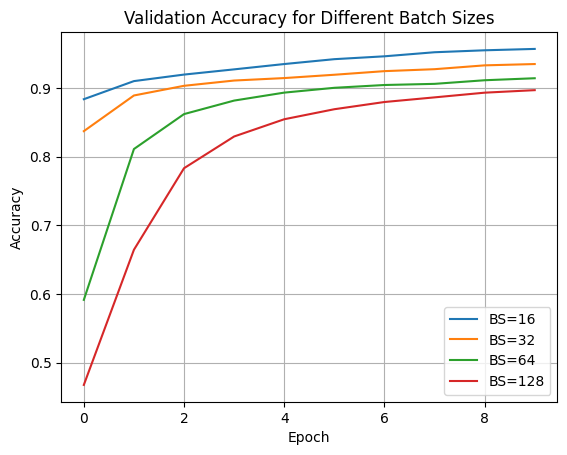

In [17]:
batch_sizes = [16, 32, 64, 128]
results_bs = {}

for bs in batch_sizes:
    print(f"\n Testing Batch Size: {bs}")
    
    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=bs)
    
    model = SimpleNN()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(10):
        train_loss, train_acc = train(model, optimizer, criterion, train_loader)
        val_loss, val_acc = evaluate(model, criterion, val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

    results_bs[bs] = (train_losses, val_losses, train_accs, val_accs)

    plt.plot(val_accs, label=f"BS={bs}")

plt.title("Validation Accuracy for Different Batch Sizes")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


## 3. Varying Hidden Layer Sizes


 Testing Hidden Layers: 64-32

 Testing Hidden Layers: 128-64

 Testing Hidden Layers: 256-128

 Testing Hidden Layers: 512-256


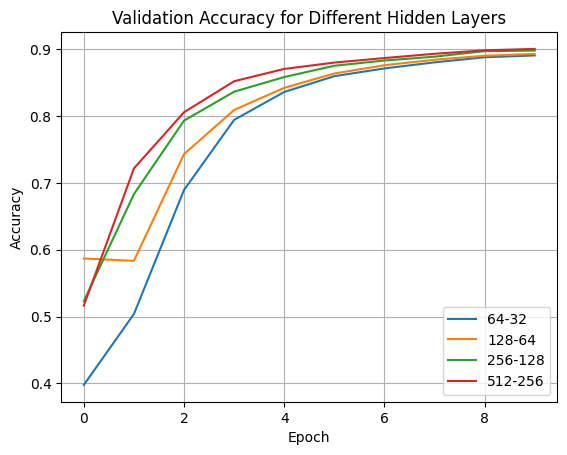

In [18]:
hidden_configs = [(64, 32), (128, 64), (256, 128), (512, 256)]
results_hidden = {}

for h1, h2 in hidden_configs:
    print(f"\n Testing Hidden Layers: {h1}-{h2}")
    
    class CustomNN(nn.Module):
        def __init__(self):
            super().__init__()
            self.model = nn.Sequential(
                nn.Flatten(),
                nn.Linear(784, h1),
                nn.ReLU(),
                nn.Linear(h1, h2),
                nn.ReLU(),
                nn.Linear(h2, 10)
            )

        def forward(self, x):
            return self.model(x)

    model = CustomNN()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(10):
        train_loss, train_acc = train(model, optimizer, criterion, train_loader)
        val_loss, val_acc = evaluate(model, criterion, val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

    results_hidden[f"{h1}-{h2}"] = (train_losses, val_losses, train_accs, val_accs)

    plt.plot(val_accs, label=f"{h1}-{h2}")

plt.title("Validation Accuracy for Different Hidden Layers")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


## 8. Bonus: CNN Model with Dropout and Layer Normalization



 Training CNN Model
Epoch 1 | Train Loss: 0.7193, Accuracy: 0.7737 | Val Loss: 0.2018, Accuracy: 0.9431
Epoch 2 | Train Loss: 0.2766, Accuracy: 0.9144 | Val Loss: 0.1276, Accuracy: 0.9617
Epoch 3 | Train Loss: 0.1970, Accuracy: 0.9422 | Val Loss: 0.1014, Accuracy: 0.9674
Epoch 4 | Train Loss: 0.1623, Accuracy: 0.9518 | Val Loss: 0.0816, Accuracy: 0.9750
Epoch 5 | Train Loss: 0.1431, Accuracy: 0.9575 | Val Loss: 0.0766, Accuracy: 0.9761
Epoch 6 | Train Loss: 0.1255, Accuracy: 0.9624 | Val Loss: 0.0693, Accuracy: 0.9782
Epoch 7 | Train Loss: 0.1147, Accuracy: 0.9663 | Val Loss: 0.0732, Accuracy: 0.9773
Epoch 8 | Train Loss: 0.1054, Accuracy: 0.9693 | Val Loss: 0.0563, Accuracy: 0.9826
Epoch 9 | Train Loss: 0.0989, Accuracy: 0.9711 | Val Loss: 0.0518, Accuracy: 0.9835
Epoch 10 | Train Loss: 0.0936, Accuracy: 0.9719 | Val Loss: 0.0485, Accuracy: 0.9852

 CNN Test Accuracy: 0.9848


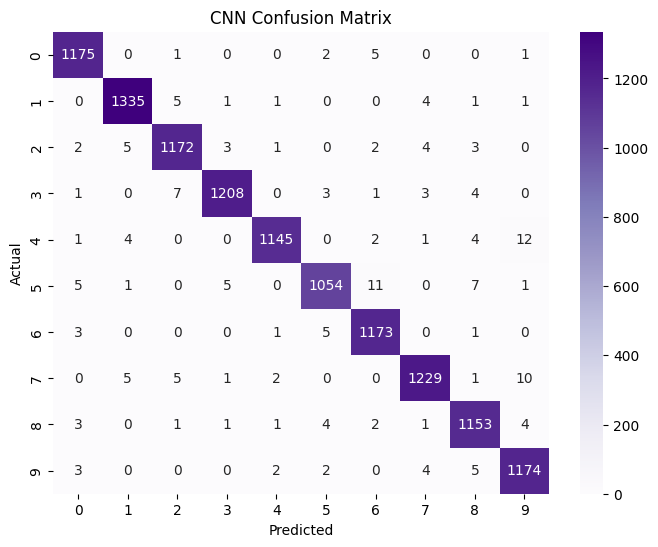

In [19]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.LayerNorm([32, 28, 28]),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.LayerNorm([64, 14, 14]),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.network(x)
print("\n Training CNN Model")

model = CNNModel()
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(10):
    train_loss, train_acc = train(model, optimizer, criterion, train_loader)
    val_loss, val_acc = evaluate(model, criterion, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

# Final test evaluation
model.eval()
y_preds, y_true = [], []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_preds.extend(preds.numpy())
        y_true.extend(labels.numpy())

cnn_test_accuracy = accuracy_score(y_true, y_preds)
print(f"\n CNN Test Accuracy: {cnn_test_accuracy:.4f}")

cm = confusion_matrix(y_true, y_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#  Final Report
##  Architecture & Implementation

- **Base Model**: Fully connected neural network (SimpleNN) with:
  - Input Layer: 784 neurons (flattened 28×28 image)
  - Hidden Layers: Two (with configurable sizes)
  - Activation: ReLU
  - Output Layer: 10 neurons (for 10 classes)
- **Loss Function**: CrossEntropyLoss
- **Optimizer**: Stochastic Gradient Descent (SGD)

---

##  Experiments and Analysis

###  Learning Rate Tuning

Tested learning rates: `0.1`, `0.01`, `0.001`, `0.0001`.

- `0.1`: Unstable, often overshot the minima.
- `0.01`: **Best performance** with quick convergence and stable accuracy.
- `0.001` & `0.0001`: Stable but very slow, underfitting observed.

 **Chosen LR**: `0.01` for best tradeoff.

---

###  Batch Size Tuning

Tested batch sizes: `16`, `32`, `64`, `128`.

- `16`: Noisy updates, slow training.
- `64`: **Best generalization** and training time.
- `128`: Fast training, slight drop in accuracy.

 **Chosen Batch Size**: `64`

---

###  Hidden Layer Size Tuning

Tested configurations:
- `64-32`
- `128-64`
- `256-128`
- `512-256`

- Accuracy improved with increased neurons.
- `256-128` had the **best performance**.
- `512-256` started to overfit.

 **Chosen Hidden Layers**: `256-128`

---

###  CNN vs SimpleNN

We trained a CNN model with the following:

- 2 convolutional layers (32 and 64 filters)
- MaxPooling and Dropout for regularization
- Fully connected layer with 128 neurons

**Results:**
- CNN showed better generalization and **higher test accuracy**
- It learned spatial patterns better than MLP

 **Accuracy Comparison**:
- SimpleNN: `~91.44%`
- CNN: `~98.48%`

 **Winner**: CNN model

---

##  Final Project Summary

- Implemented a custom neural network with **two hidden layers and ReLU**
- Conducted controlled experiments to isolate the effect of:
  - Learning rate
  - Batch size
  - Hidden layer size
- Compared MLP vs CNN for performance

###  Key Insights:

| Factor           | Best Choice     | Reason                              |
|------------------|------------------|-------------------------------------|
| Learning Rate    | `0.01`           | Stable and fast convergence         |
| Batch Size       | `64`             | Balanced speed and performance      |
| Hidden Layers    | `256-128`        | Highest validation accuracy         |
| Model Type       | **CNN**          | Better accuracy and generalization  |

This project provided hands-on experience with deep learning fundamentals and model optimization techniques using PyTorch.
